In [1]:
import random

import numpy as np

from src.modules.training.datasets.main_dataset import MainDataset
from src.utils.setup import setup_data
# Import all important ML packages.
from src.utils.stratified_splitter import create_stratified_cv_splits

## EEG

### Load in all the data

In [2]:
#Start by setting up the data.
path = "../../data/raw"
X, y = setup_data(path)

### Create a dataset

In [3]:
#Create a dataset
train_indices, test_indices = create_stratified_cv_splits(X.meta, y, int(1 / 0.2))[0]

dataset = MainDataset("eeg", X, y, indices=list(range(len(y))))

#Sample 10000 random indices from the training dataset and 2000 from the validation dataset.
random.seed(42)
train_sample = random.sample(list(train_indices), 5000)
val_sample = random.sample(list(test_indices), 5000)

X_train = np.array([dataset.__getitem__(i)[0] for i in train_sample])
y_train = np.array([dataset.__getitem__(i)[1] for i in train_sample])

X_test = np.array([dataset.__getitem__(i)[0] for i in val_sample])
y_test = np.array([dataset.__getitem__(i)[1] for i in val_sample])

### Feature engineering

In [4]:
# Let's try statistical features such as rolling mean to start with on all channels 
# and then try to use the rolling mean on the channels that are most important.

In [5]:

import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from tqdm import tqdm


def channel_selection(data, channels):
    """
    Selects the specified channels from a 3D numpy array.
    
    Parameters:
        data (numpy.ndarray): The input data of shape (samples, sequence_length, channels).
        channels (list): The list of channels to select.
        
    Returns:
        numpy.ndarray: The data with the selected channels.
    """
    return data[:, :, channels]


def apply_downsampling(data, factor):
    """
    Downsamples a 3D numpy array by averaging over windows of the specified factor.
    
    Parameters:
        data (numpy.ndarray): The input data of shape (samples, sequence_length, channels).
        factor (int): The downsampling factor.
        
    Returns:
        numpy.ndarray: The downsampled data.
    """
    reshaped_data = data.reshape(data.shape[0], data.shape[1] // factor, factor, data.shape[2])

    # Compute the mean along the new axis that represents the blocks to be averaged
    downsampled_data = reshaped_data.mean(axis=2)

    return downsampled_data


def apply_rolling_operation(data, window_size, operation):
    """
    Applies a rolling operation (e.g., mean, std, min, max) to a 3D numpy array.
    
    Parameters:
        data (numpy.ndarray): The input data of shape (samples, sequence_length, channels).
        window_size (int): The size of the rolling window.
        operation (callable): The operation to apply within the rolling window.
        
    Returns:
        numpy.ndarray: The data with the rolling operation applied.
    """
    # Initialize the result array with NaNs to preserve original shape
    result = np.full(data.shape, np.nan)

    # Apply the rolling operation to each sample and channel
    for sample_idx in tqdm(range(data.shape[0])):
        for channel_idx in range(data.shape[2]):
            sequence = data[sample_idx, :, channel_idx]
            # Use sliding_window_view to create rolling windows
            windows = sliding_window_view(sequence, window_shape=window_size)
            # Apply the operation across the windows' axis (axis=-1) and assign to the result
            # Center the result of the operation in the middle of the window
            operation_result = operation(windows, axis=-1)
            start_index = window_size // 2
            end_index = start_index + operation_result.shape[0]
            result[sample_idx, start_index:end_index, channel_idx] = operation_result

            #Forward and backward fill the NaNs
            result[sample_idx, :, channel_idx] = pd.Series(result[sample_idx, :, channel_idx]).fillna(method="ffill").fillna(method="bfill")
    return result


def rolling_plot(X_train, X_test, window_size, operation):
    #Create a plot before and after.
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    #Plot the original data for the first sample and channel
    ax[0].plot(X_train[0, :, 0])
    ax[0].set_title("Original data")

    # Assuming X_train and X_test are your datasets
    X_train = apply_rolling_operation(X_train, window_size, operation)
    X_test = apply_rolling_operation(X_test, window_size, operation)

    #Plot the transformed data for the first sample and channel
    ax[1].plot(X_train[0, :, 0])
    ax[1].set_title(f"Transformed data - rolling {str(operation)} with window size {window_size}")

    plt.show()

    return X_train, X_test

### Preprocess the data

In [6]:
#Remove the time dimension by flattening the data from (n, sequence_length, channels) to (n*sequence_length, channels).
def preprocess(X_train, X_test, y_train, y_test):
    sequence_length = X_train.shape[1]

    X_train = X_train.reshape(-1, X_train.shape[2])
    X_test = X_test.reshape(-1, X_test.shape[2])

    #Also process the labels from size (n, channels) to (n*sequence_length, channels).
    y_train = np.repeat(y_train, repeats=sequence_length, axis=0)
    y_test = np.repeat(y_test, repeats=sequence_length, axis=0)

    #Clip the data between -1024 and 1024.
    X_train = np.clip(X_train, -1024, 1024)
    X_test = np.clip(X_test, -1024, 1024)

    #Divide the data by 32
    X_train = X_train / 32
    X_test = X_test / 32

    #Set NaN to 0
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)

    #Divide the labels by the sum of the labels to get a probability distribution.
    y_train = y_train / np.sum(y_train, axis=1).reshape(-1, 1)
    y_test = y_test / np.sum(y_test, axis=1).reshape(-1, 1)

    #Randomly shuffle train data
    np.random.seed(42)
    p = np.random.permutation(len(X_train))
    X_train = X_train[p]
    y_train = y_train[p]

    #One hot encode the labels
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)

    return X_train, X_test, y_train, y_test

In [7]:
import xgboost as xgb


def train(X_train, X_test, y_train, y_test):
    #Create a model
    model = xgb.XGBClassifier(num_class=6, n_estimators=100, max_depth=10, learning_rate=0.1, verbosity=1, early_stopping_rounds=10)
    # Use early stopping to stop the training if the validation score does not improve for 10 rounds.
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    return model

In [8]:
#Calculate the accuracy and create a confusion matrix with seaborn
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from src.scoring.kldiv import KLDiv

def plot_confusion_matrix(y_test, y_pred, disable_plot=False):


    #Set the axis labels
    #Create the confusion matrix
    #Take the argmax of the probabilities to get the predicted class
    y_test_final = np.argmax(y_test, axis=1)
    y_pred_final = np.argmax(y_pred, axis=1)
    kldiv = KLDiv()
    score = kldiv(y_test, y_pred)
    accuracy = accuracy_score(y_test_final, y_pred_final)

    
    
    if not disable_plot:
        fig, ax = plt.subplots(figsize=(10, 10))
        print(f"KLDiv: {score}")
        print(f"Classification accuracy:  {accuracy}")
        sns.heatmap(confusion_matrix(y_test_final, y_pred_final), annot=True, fmt="d", ax=ax)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
    
        #Set the labels
        ax.set_xticklabels(["Seizure", "Lpd", "Gpd", "Lrda", "Grda", "Other"])
        ax.set_yticklabels(["Seizure", "Lpd", "Gpd", "Lrda", "Grda", "Other"])
        plt.show()
    return score, accuracy


In [9]:
def plot_feature_importances(model, feature_names, tsfresh=False):
    #Plot the feature importances with xgboost horizontally
    fig, ax = plt.subplots(1, 2, figsize=(35, 10))

    xgb.plot_importance(model, ax=ax[0], importance_type="weight")
    if not tsfresh:
        ax[0].set_yticklabels(feature_names)

    #Show plots/brain.png on the right
    ax[1].imshow(plt.imread("../../plots/brain.png"))

In [10]:
def pipeline(X_train, X_test, y_train, y_test):
    #Channel selection
    all_channels = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    channel_indices = range(len(all_channels))
    channel_dict = dict(zip(all_channels, channel_indices))
    selected_c = all_channels
    channels = [channel_dict[c] for c in selected_c]
    window_size = 175
    operation = np.std

    #Select the channels
    X_train = channel_selection(X_train, channels)
    X_test = channel_selection(X_test, channels)

    #Downsample the data
    X_train = apply_downsampling(X_train, 10)
    X_test = apply_downsampling(X_test, 10)

    #Apply the rolling operation
    X_train, X_test = rolling_plot(X_train, X_test, window_size, operation)

    #Now preprocess the data
    X_train, X_test, y_train, y_test = preprocess(X_train, X_test, y_train, y_test)

    #Train the model
    model = train(X_train, X_test, y_train, y_test)

    #Make predictions
    y_pred = model.predict(X_test)

    #Plot the confusion matrix
    plot_confusion_matrix(y_test, y_pred)

    #Plot the feature importances
    feature_names = np.array(X.eeg[list(X.eeg.keys())[0]].columns)[channels]
    plot_feature_importances(model, feature_names)

In [11]:
#Run the pipeline
#pipeline(X_train, X_test, y_train, y_test)

In [12]:
# Now lets use tsfresh for feature engineering

def preprocess_to_df(X, all_channels):
    
    #Clip the data between -1024 and 1024.
    X = np.clip(X, -1024, 1024)
    #Divide the data by 32
    X = X / 32
    #Set NaN to 0
    X = np.nan_to_num(X)
    id = np.repeat(range(X.shape[0]), X.shape[1])
    X = X.reshape(-1, X.shape[2])
    df = pd.DataFrame(X, columns=all_channels)
    del X
    df["id"] = id
    return df

def apply_combine(X: )


def apply_rolling(X: pd.DataFrame, window_sizes: list, operations: list):
    """
    Applies a rolling operation (e.g., mean, std, min, max) to a 3D numpy array.
    
    Parameters:
        data (numpy.ndarray): The input data of shape (samples, sequence_length, channels).
        window_size (int): The size of the rolling window.
        operation (callable): The operation to apply within the rolling window.
        
    Returns:
        numpy.ndarray: The data with the rolling operation applied.
    """
    # Initialize the result array with NaNs to preserve original shape
    result = pd.DataFrame()
    # Apply the rolling operation to each sample and channel (exclude Id)
    for channel, window_size, operation in zip(X.columns[:-1], window_sizes, operations): 
        #Convert operation from string to callable
        print(X[channel].shape)
        result[channel] = X[channel].groupby(X["id"]).rolling(window=window_size).agg(operation).ffill().bfill().astype(np.float32)
        #Rename the current column
        result.rename(columns={channel: f"{channel}_{operation}_{window_size}"}, inplace=True)
        
    return result


def preprocess_tf(y):
    #One hot encode the labels
    y = np.argmax(y, axis=1)
    #Repeat y based on 
    return y


In [13]:
from tsfresh import select_features


def pipeline_hand(runs, X_train, X_test, y_train, y_test):
    
    all_channels = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    unary_ops = ['abs']
    binary_ops = ['add', 'sub', 'mul', 'div']
    stats = ['mean', 'std', 'min', 'max', 'median', 'skew','kurt']
    window_sizes = [6, 12, 36, 50, 90, 180, 360, 500, 1000]
    downsampling = [10]
    
    channel_indices = range(len(all_channels))
    channel_dict = dict(zip(all_channels, channel_indices))
    
    
    scores = dict()
    accuracies = dict()
    
    for i in tqdm(range(runs)): 
        
        #Select a random number of channels, for now lets do one.
        # num_channels = random.randint(1, 20)
        num_channels = 1
        selected_c = random.sample(all_channels, num_channels)
        channels = [channel_dict[c] for c in selected_c]
        
        # Select downsampling
        downsample = random.choice(downsampling)
        
        # Select window size
        window_size = random.choice(window_sizes)
        
        # Select operation
        operation = random.choice(stats)

        #Select the channels
        X_train_curr = channel_selection(X_train, channels)
        X_test_curr = channel_selection(X_test, channels)
        
        #Repeat y based on the sequence length
        y_train_curr = np.repeat(y_train, repeats=X_train.shape[1] / downsample, axis=0)
        y_test_curr = np.repeat(y_test, repeats=X_test.shape[1] / downsample, axis=0)
    
        #Downsample the data
        X_train_curr = apply_downsampling(X_train_curr, downsample)
        X_test_curr = apply_downsampling(X_test_curr, downsample)
    

        #Apply the rolling operation
        X_train_curr = preprocess_to_df(X_train_curr, selected_c)
        X_test_curr = preprocess_to_df(X_test_curr, selected_c)
        print(X_train_curr.shape)
        X_train_curr = apply_rolling(X_train_curr, [window_size], [operation])
        X_test_curr = apply_rolling(X_test_curr, [window_size], [operation])
        
        #Now preprocess the data
        y_train_curr_final = preprocess_tf(y_train_curr)
        y_test_curr_final = preprocess_tf(y_test_curr)
        
        #Train the model
        model = train(X_train_curr, X_test_curr, y_train_curr_final, y_test_curr_final)
    
        #Make predictions with probabilities
        y_pred = model.predict_proba(X_test_curr)
    
        #Plot the confusion matrix
        score, accuracy = plot_confusion_matrix(y_test_curr, y_pred, disable_plot=True)
        
        #Save the scores
        scores[f"{selected_c[0]}-{downsample}-{window_size}-{operation}"] = score
        accuracies[f"{downsample}-{window_size}-{operation}"] = accuracy
        
        #Print the current run with the score and accuracy in a nice format.
        print(f"Run {i} with {num_channels} channels, channel {selected_c}, downsample {downsample}, window size {window_size}, operation {operation} has a score of {score} and an accuracy of {accuracy}")
    
        #Plot the feature importances
        #feature_names = np.array(X.eeg[list(X.eeg.keys())[0]].columns)[channels]
        #plot_feature_importances(model, feature_names, tsfresh=True)
    
    return scores, accuracies

In [14]:
##Load accuracies and scores from file if it exists, else run pipeline
import os
if os.path.exists("scores.pkl") and os.path.exists("accuracies.pkl"):
    import pickle
    with open("scores.pkl", "rb") as f:
        scores = pickle.load(f)
    with open("accuracies.pkl", "rb") as f:
        accuracies = pickle.load(f)
else:
    scores, accuracies = pipeline_hand(25, X_train, X_test, y_train, y_test) 
    #Write to file using pickle
    import pickle
    with open("scores.pkl", "wb") as f:
        pickle.dump(scores, f)
    with open("accuracies.pkl", "wb") as f:
        pickle.dump(accuracies, f)

In [15]:
#From the accuracies
#Get the 10 keys with the top accuracy
top_10 = sorted(accuracies, key=accuracies.get, reverse=True)[:10]
#Get the 10 keys with the lowest score
top_10_score = sorted(scores, key=scores.get, reverse=False)[:10]

In [16]:

#Train a config with these keys
def train_config(X_train, X_test, y_train, y_test, config):
    all_channels = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    channel_indices = range(len(all_channels))
    channel_dict = dict(zip(all_channels, channel_indices))
    
    curr_channels = [channel_dict[c[1:]] for c in config[0]]
    
    #Select the channels
    X_train_curr = channel_selection(X_train, curr_channels)
    X_test_curr = channel_selection(X_test, curr_channels)
    
    #Repeat y based on the sequence length
    y_train_curr = np.repeat(y_train, repeats=X_train.shape[1] / config[1][0], axis=0)
    y_test_curr = np.repeat(y_test, repeats=X_test.shape[1] / config[1][0], axis=0)
    
    #Downsample the data
    X_train_curr = apply_downsampling(X_train_curr, config[1][0])
    X_test_curr = apply_downsampling(X_test_curr, config[1][0])
    
    #Apply the rolling operation
    X_train_curr = preprocess_to_df(X_train_curr, config[0])
    X_test_curr = preprocess_to_df(X_test_curr, config[0])
    X_train_curr = apply_rolling(X_train_curr, config[2], config[3])
    X_test_curr = apply_rolling(X_test_curr, config[2], config[3])
    
    #Now preprocess the data
    y_train_curr_final = preprocess_tf(y_train_curr)
    y_test_curr_final = preprocess_tf(y_test_curr)
    
    #Train the model
    model = train(X_train_curr, X_test_curr, y_train_curr_final, y_test_curr_final)
    
    #Make predictions with probabilities
    y_pred = model.predict_proba(X_test_curr)
    
    #Plot the confusion matrix
    score, accuracy = plot_confusion_matrix(y_test_curr, y_pred, disable_plot=False)
    
    #Plot the feature importances
    feature_names = X_train_curr.columns
    plot_feature_importances(model, feature_names, tsfresh=True)
    return score, accuracy

(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
(20000000,)
KLDiv: 1.2848340097472752
Classification accuracy:  0.3024607


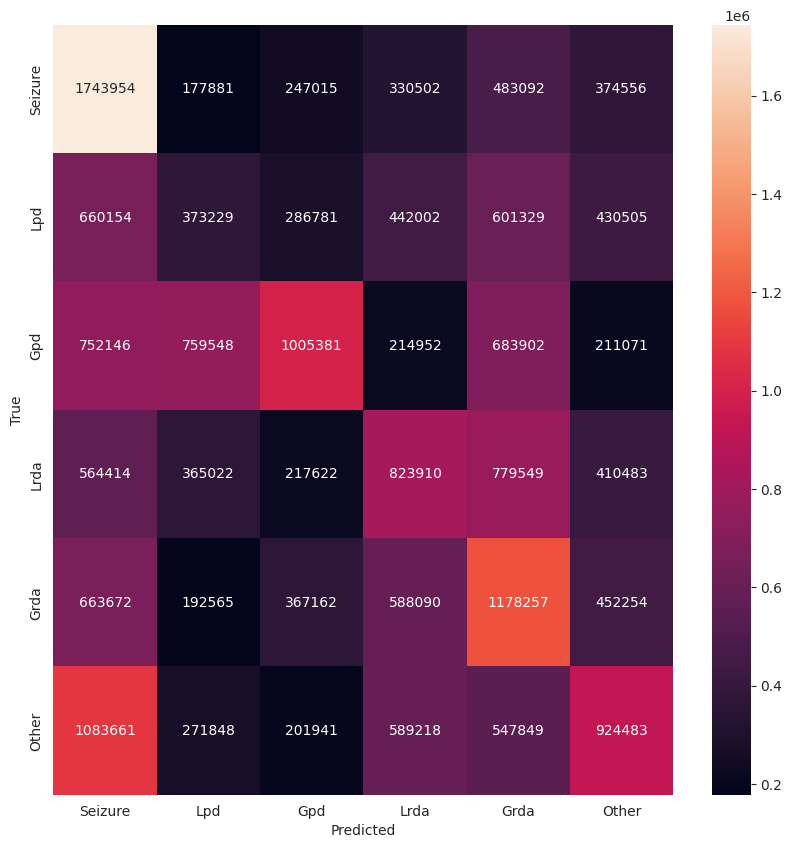

Score: 1.2848340097472752, Accuracy: 0.3024607


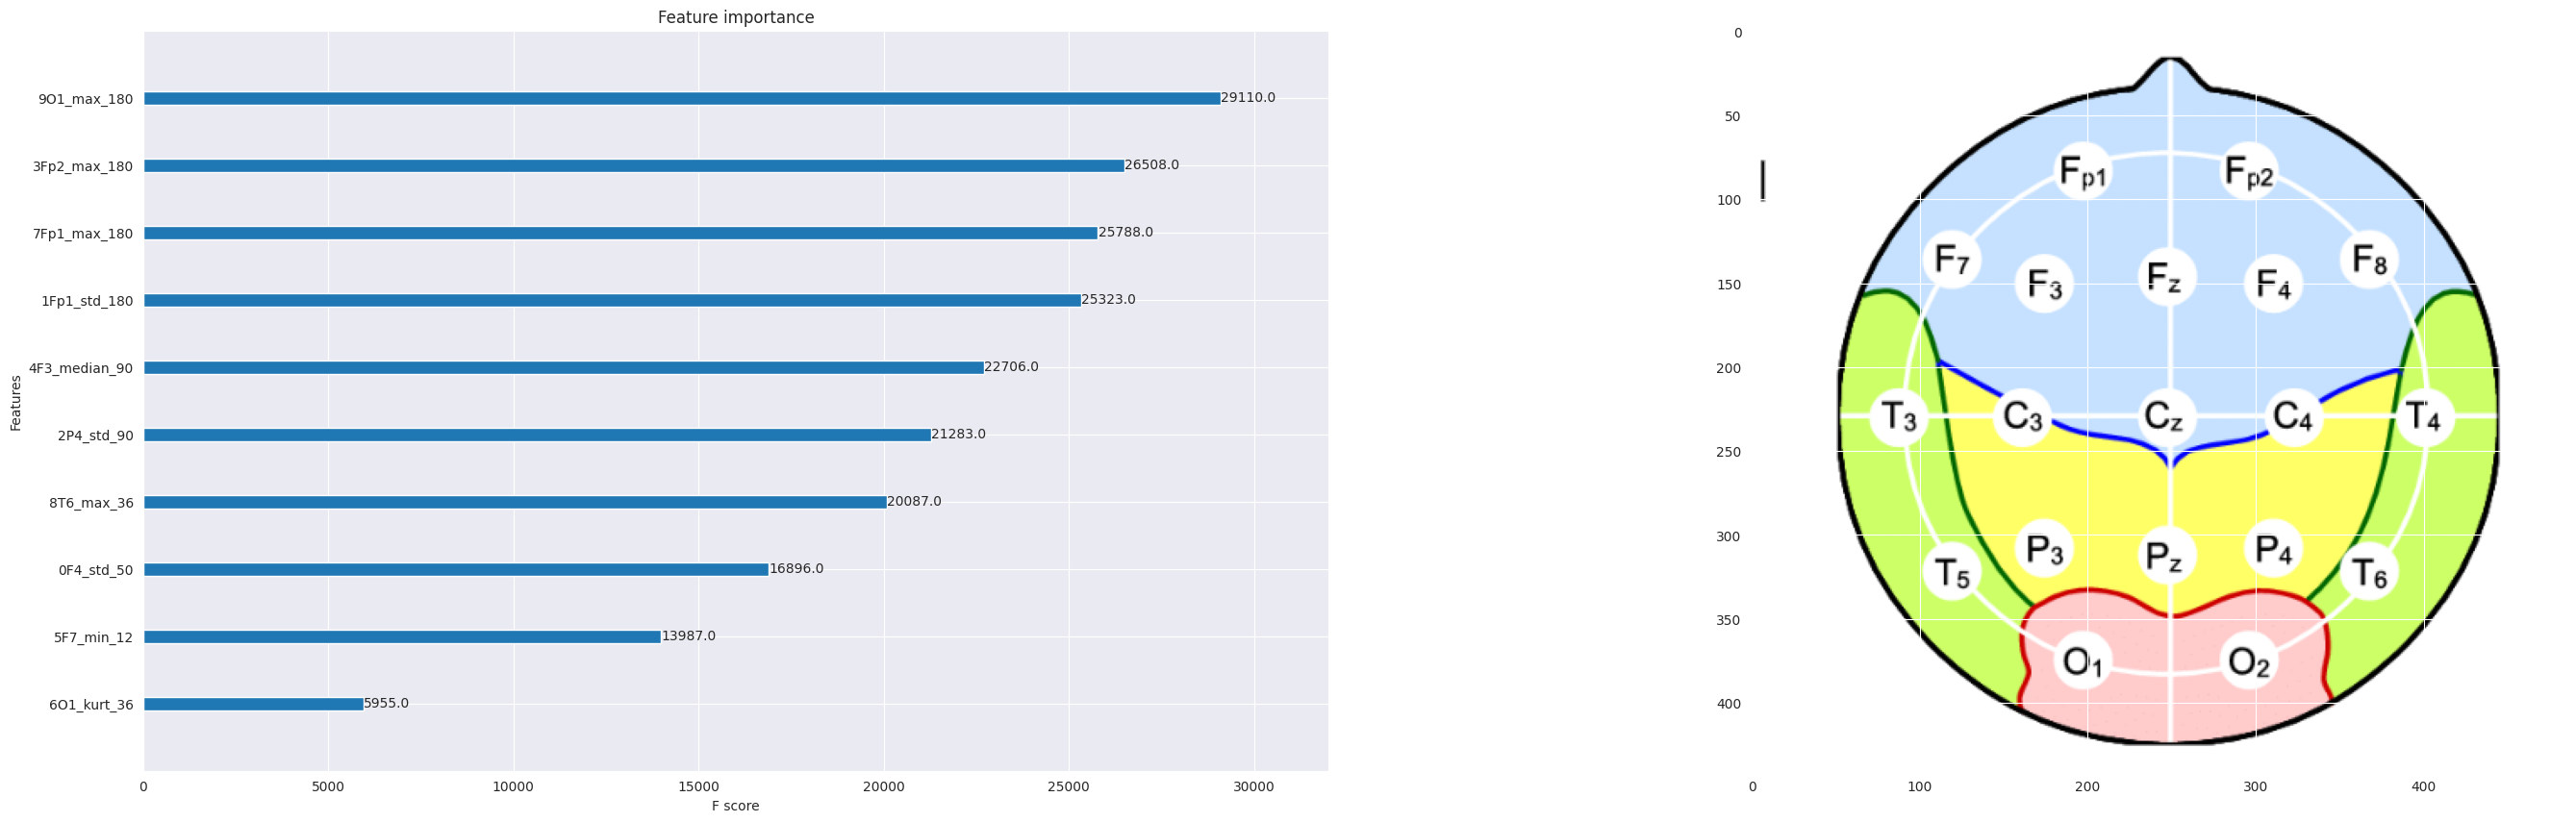

In [17]:
config_channels = [str(i) + config.split("-")[0][2:-2] for i,config in zip(range(len(top_10_score)), top_10_score)]
config_downsample = [int(config.split("-")[1]) for config in top_10_score]
config_window = [int(config.split("-")[2]) for config in top_10_score]
config_operation = [config.split("-")[3] for config in top_10_score]
config = [config_channels, config_downsample, config_window, config_operation]


score, accuracy = train_config(X_train, X_test, y_train, y_test, config)
print(f"Score: {score}, Accuracy: {accuracy}")